# Time Series Analysis of HiPSCats
Here we will use the lsdb framework to load ztf objects and sources then perform quick computations obtain some lightcurve information. 

We will do the same joint analysis as before, where we will find a subset of high-proper motion stars with gaia, that have a lot of observations in ztf. Here, we will join the result to the ztf source catalog, and extract lightcurve information for our subset.

In [1]:
import lsdb
from lsdb import lsdb_client
client = lsdb_client(dask_on_ray=True, num_workers=6)

2023-11-03 20:13:16,707	INFO worker.py:1621 -- Started a local Ray instance.
/astro/users/sdwyatt/anaconda3/envs/lsdb_demo/lib/python3.10/site-packages/dask/config.py:694: UserWarning: Configuration key "shuffle" has been deprecated. Please use "dataframe.shuffle.algorithm" instead
  warnings.warn(


In [2]:
from hipscat.inspection.almanac import Almanac
from hipscat.ADASS_Tutorial.credentials import read_storage_options

path_to_cloud_catalog = "abfs:///hipscat/catalogs/almanac"
storage_options = read_storage_options()

cloud_almanac = Almanac(dirs=[path_to_cloud_catalog], storage_options=storage_options)
for catalog in cloud_almanac.catalogs():
    print(catalog)

gaia
ztf_dr14
ztf_source


#### Here we gather our datasets that have already been partitioned in the hipscat manner
\*we are aware that there is a bug in loading extremely large catalog (ztf_source) and are working around on a fix

In [3]:
gaia = lsdb.from_almanac("gaia", cloud_almanac, columns=['ra', 'dec', 'pmra', 'pmdec'])
ztf = lsdb.from_almanac("ztf_dr14", cloud_almanac, columns=['ra', 'dec', 'ps1_objid', 'nobs_g', 'nobs_r', 'nobs_i', 'mean_mag_g', 'mean_mag_r', 'mean_mag_i'])
ztf_sources = lsdb.from_almanac("ztf_source", cloud_almanac)

#### Cull the gaia through conesearch, cross_match with gaia, and then perform a cut on density of observation

In [4]:
import numpy as np
ztf_sample = gaia.cone_search(
    ra=31,
    dec=30,
    radius=1,
).crossmatch(
    ztf
).query(
    "nobs_g_ztf_dr14 > 20 and nobs_r_ztf_dr14 > 20 and nobs_i_ztf_dr14 > 20"
).assign(
    g_minus_r=lambda x: x["mean_mag_g_ztf_dr14"]-x["mean_mag_r_ztf_dr14"],
    r_minus_i=lambda x: x["mean_mag_r_ztf_dr14"]-x["mean_mag_i_ztf_dr14"]
).compute()

In [5]:
ztf_sample

,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,_DIST,g_minus_r,r_minus_i
_hipscat_index,,,,,,,,,,,,,,,,
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,17.355165,16.185900,15.758949,0.000008,1.169265,0.426951
599522540544589824,31.429665,29.079871,4.824305,-15.137056,31.429661,29.079877,142890314296516472,467,610,45,18.527807,17.132010,16.466106,0.000007,1.395797,0.665904
599522768177856512,31.406200,29.082557,-1.012378,-3.243405,31.406189,29.082573,142890314062089682,478,613,46,14.323063,13.455056,13.143231,0.000019,0.868007,0.311826
599522841192300544,31.462827,29.086511,0.567992,-0.572760,31.462810,29.086524,142900314628284417,340,476,35,20.244104,19.883095,19.806608,0.000020,0.361009,0.076487
599522849782235136,31.463904,29.089568,3.515846,-4.241290,31.463900,29.089582,142900314638728086,473,605,43,18.525228,18.328787,18.316226,0.000015,0.196440,0.012561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602924150348054528,30.358062,30.828354,18.293109,1.556143,30.358076,30.828373,144990303580194520,468,716,47,19.302731,17.829468,16.789261,0.000023,1.473263,1.040206
602924171822891008,30.348836,30.818440,15.094414,-5.270110,30.348845,30.818461,144980303488052646,491,648,56,15.464070,14.815594,14.562860,0.000023,0.648476,0.252734
602924171822891009,30.361674,30.824070,15.220351,-12.681022,30.361684,30.824079,144980303616449402,499,721,48,17.585441,16.964811,16.788843,0.000012,0.620630,0.175968


#### Object science: Color-Color diagrams
We calculated colors on from average magnitude values, lets see what they look like.

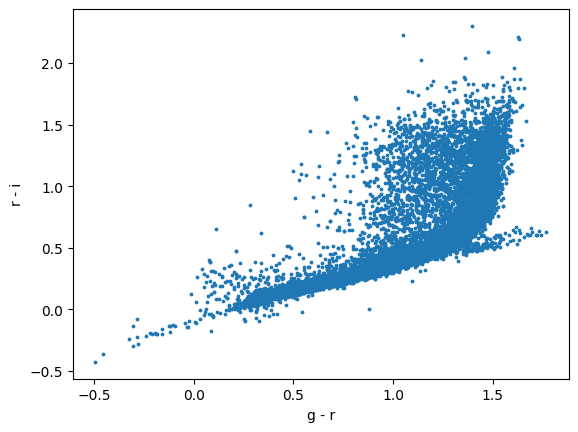

In [6]:
import matplotlib.pyplot as plt
ax = plt.subplot()
im = ax.scatter(
    ztf_sample["g_minus_r"],
    ztf_sample["r_minus_i"],
    s=3,
)
ax.set_xlabel("g - r")
ax.set_ylabel("r - i")
plt.show()

#### Since we still want to perform a join on sources to obtain lightcurve information, we have to re-hipscat it at a high-order.
There is a slight art to this to minimize the number of files we want to join to.

In [7]:
type(ztf_sample)

pandas.core.frame.DataFrame

In [8]:
ztf_sample_re_hips = lsdb.from_dataframe(
    ztf_sample, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia"
)
print(type(ztf_sample))

<class 'pandas.core.frame.DataFrame'>


#### Next, join with ztf sources on their ps1_objectid

In [9]:
ztf_sample_with_sources = ztf_sample_re_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid"
).compute()

In [10]:
print(type(ztf_sample_with_sources))
ztf_sample_with_sources

<class 'pandas.core.frame.DataFrame'>


,ra_gaia,dec_gaia,pmra_gaia,pmdec_gaia,ra_ztf_dr14,dec_ztf_dr14,ps1_objid_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,...,catflags,fieldID,mag,magerr,mjd,rcID,band,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0,604,17.314888,0.018315,59268.15442,53,g,7,0,8519
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0,604,17.350910,0.018652,59168.22101,53,g,7,0,8519
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0,604,17.379185,0.018924,59170.22956,53,g,7,0,8519
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0,604,17.377768,0.018910,59164.35017,53,g,7,0,8519
599522536249622528,31.427439,29.079228,4.583446,-15.204893,31.427433,29.079234,142890314274265699,472,609,45,...,0,604,17.365601,0.018792,59172.24582,53,g,7,0,8519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
602924987866677248,30.387019,30.844146,-1.234435,-0.523366,30.387044,30.844180,145010303870113490,75,404,33,...,0,652,20.407598,0.153102,58425.28034,9,r,7,0,8568
602924987866677248,30.387019,30.844146,-1.234435,-0.523366,30.387044,30.844180,145010303870113490,75,404,33,...,0,652,20.401468,0.152558,58349.47579,9,r,7,0,8568
602924987866677248,30.387019,30.844146,-1.234435,-0.523366,30.387044,30.844180,145010303870113490,75,404,33,...,0,1649,20.486242,0.152677,58426.27688,40,r,7,0,8568


#### Performing time-series analysis of one object

In [11]:
one_object = ztf_sample_with_sources.query("_hipscat_index == 599522536249622528")
one_object_gband = one_object.query("band == \"g\"")
one_object_rband = one_object.query("band == \"r\"")
one_object_iband = one_object.query("band == \"i\"")

gband_mjd, gband_mag, gband_magerr = one_object_gband["mjd"], one_object_gband["mag"], one_object_gband["magerr"]
rband_mjd, rband_mag, rband_magerr = one_object_rband["mjd"], one_object_rband["mag"], one_object_rband["magerr"]
iband_mjd, iband_mag, iband_magerr = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]

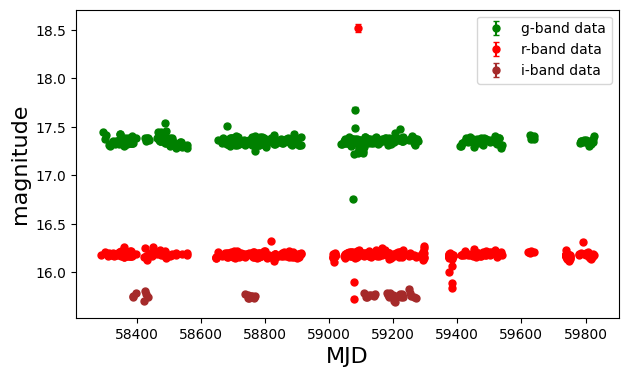

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.errorbar(gband_mjd, gband_mag, yerr=gband_magerr,\
             c="green", label = 'g-band data', ls='', marker='.', ms=10, capsize=2)
plt.errorbar(rband_mjd, rband_mag, yerr=rband_magerr,\
             c="red", label = 'r-band data', ls='', marker='.', ms=10, capsize=2)
plt.errorbar(iband_mjd, iband_mag, yerr=iband_magerr,\
             c="brown", label = 'i-band data', ls='', marker='.', ms=10, capsize=2)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.legend()

#### Time Series analysis of many objects

In [13]:
from astropy.timeseries import LombScargle as ls
import pandas as pd
import numpy as np
def lightcurve_variability_analysis(df):
    df_gband = df.query("band == \"g\"")
    df_rband = df.query("band == \"r\"")
    df_iband = df.query("band == \"i\"")

    # g_ls = ls(df_gband["mjd"], df_gband["mag"], df_gband["magerr"])
    # g_freq, g_power = g_ls.autopower()

    r_ls = ls(df_rband["mjd"], df_rband["mag"], df_rband["magerr"])
    r_freq, r_power = r_ls.autopower()

    # i_ls = ls(df_iband["mjd"], df_iband["mag"], df_iband["magerr"])
    # i_freq, i_power = i_ls.autopower()


    return pd.DataFrame(
        {
            "ps1_objid" : [df["ps1_objid"].values.tolist()[0]],
            "r_best_freq" : [r_freq[np.argmax(r_power)]],
            "r_best_power" : [r_power.max()],
            "r_far" : [r_ls.false_alarm_probability(r_power.max())],
            "r_mag_std" : [np.std(df_rband["mag"])]
        }
    )

In [14]:
ztf_sample_with_sources_rehips = lsdb.from_dataframe(
    ztf_sample_with_sources, 
    lowest_order=5, 
    highest_order=8, 
    set_hipscat_index=False, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia",
    threshold=1_000_000
)
print(type(ztf_sample_with_sources_rehips))

<class 'lsdb.catalog.catalog.Catalog'>


In [15]:
return_meta = {
    "ps1_objid" : "i8",
    "r_best_freq" : "f8",
    "r_best_power" : "f8",
    "r_far" : "f8",
    "r_mag_std" : "f8"
}

variability_analysis = ztf_sample_with_sources_rehips.for_each(
    key="ps1_objid",
    ufunc=lightcurve_variability_analysis,
    meta=return_meta
).compute()

In [16]:
variability_analysis.sort_values("r_mag_std", ascending=False)

,,ps1_objid,r_best_freq,r_best_power,r_far,r_mag_std
ps1_objid,,,,,,
144850309344693189,0,144850309344693189,0.997221,0.431581,2.347969e-73,0.676935
143980309525569137,0,143980309525569137,0.000065,0.322836,1.410488e-57,0.634871
142930313408294857,0,142930313408294857,0.501380,0.300858,2.005086e-32,0.604971
143670319079627980,0,143670319079627980,0.071587,0.177041,6.762467e-04,0.545068
143020313760991609,0,143020313760991609,0.000066,0.815541,1.103500e-160,0.495740
...,...,...,...,...,...,...
145020306295216352,0,145020306295216352,0.006372,0.318012,2.056149e-21,0.014885
144680316565538205,0,144680316565538205,0.184208,0.145879,7.236077e-01,0.014501
144640316412992940,0,144640316412992940,0.067673,0.153127,6.081755e-01,0.014452


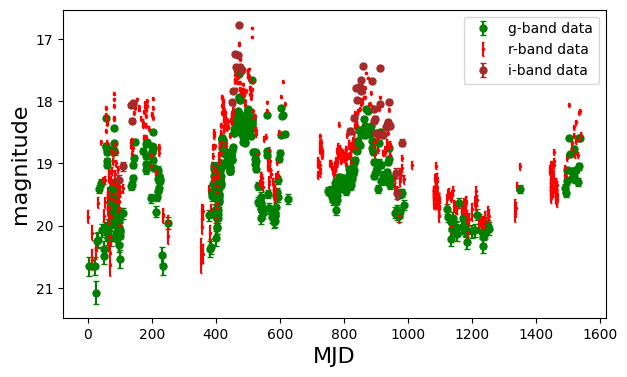

In [40]:
period = 1.0/0.997221
one_object = ztf_sample_with_sources.query("ps1_objid == 144850309344693189")
one_object_gband = one_object.query("band == \"g\"")
one_object_rband = one_object.query("band == \"r\"")
one_object_iband = one_object.query("band == \"i\"")

gband_mjd, gband_mag, gband_magerr = one_object_gband["mjd"], one_object_gband["mag"], one_object_gband["magerr"]
rband_mjd, rband_mag, rband_magerr = one_object_rband["mjd"], one_object_rband["mag"], one_object_rband["magerr"]
iband_mjd, iband_mag, iband_magerr = one_object_iband["mjd"], one_object_iband["mag"], one_object_iband["magerr"]



r_mjd_0 = rband_mjd.values.tolist()
t0 = min(r_mjd_0)
g_mjd_0 = [x - t0 for x in gband_mjd.values.tolist()]
r_mjd_0 = [x - t0 for x in r_mjd_0]
i_mjd_0 = [x - t0 for x in iband_mjd.values.tolist()]

folded_gmjd = [x % period for x in g_mjd_0]
folded_rmjd = [x % period for x in r_mjd_0]
folded_imjd = [x % period for x in i_mjd_0]

plt.figure(figsize=(7,4))
plt.errorbar(g_mjd_0, gband_mag, yerr=gband_magerr,\
              c="green", label = 'g-band data', ls='', marker='.', ms=10, capsize=2)
plt.errorbar(r_mjd_0, rband_mag, yerr=rband_magerr,\
             c="red", label = 'r-band data', ls='', marker='.', ms=3, capsize=1)
plt.errorbar(i_mjd_0, iband_mag, yerr=iband_magerr,\
             c="brown", label = 'i-band data', ls='', marker='.', ms=10, capsize=2)
plt.xlabel('MJD', fontsize=16)
plt.ylabel('magnitude', fontsize=16)
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
client.shutdown()